In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import json
from prcvd.img.core import (MaskedImg)
import requests
import ubiops

/home/fortville/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
## Initialize API

In [4]:
from prcvd.core import json_to_dict
    

def blob_from_fp(fp):
    return api.blobs_create(
            project_name=PROJECT_NAME,
            file=str(ls[2])
    )
    
class Client:
    def __init__(self, project_name, deployment_name, 
                 deployment_version, input_spec, 
                 output_spec, api_key):
        self.project_name = project_name
        self.deployment_name = deployment_name
        self.deployment_version = deployment_version
        self.input_spec = input_spec #dict
        self.output_spec = output_spec #dict
        self.api_key = api_key
        self.response = None
        self.output_data = None
        self.url_fmt = '{host}/projects/{proj}/'
        self.req_fmt = 'deployments/{dname}/versions/{dver}/request'
        self.req_url = os.path.join(
            url_fmt.format(
                host=secrets['HOST'], 
                proj=PROJECT_NAME),
            req_fmt.format(
                dname=DEPLOYMENT_NAME, 
                dver=DEPLOYMENT_VERSION
            )
        )
        self.client = ubiops.ApiClient(
            ubiops.Configuration(
                api_key={'Authorization': self.api_key}, 
                host=secrets['HOST'])
        )

        self.api = ubiops.CoreApi(client)
        
    
    def request(self, data):
        pass


ImportError: cannot import name 'json_to_dict'

In [7]:
imgs = Path('/data1/data/skin-tone/from_zenodo/Media/MediaForExport')
ls = [
    fp for fp in list(imgs.iterdir()) 
    if str(fp)[-4:] == '.jpg'
]

In [8]:
SECRETS_FP = Path(os.getenv('HOME'))/'code/.secrets/ubiops.json'
secrets = json_to_dict(fp=SECRETS_FP)
OUTPUT_SPEC_FP = Path(os.getcwd()).parent/'ubiops_output_spec.json'
output_spec = json_to_dict(fp=OUTPUT_SPEC_FP)

PROJECT_NAME = "facial-profile"
DEPLOYMENT_NAME = 'endtoend-3'
DEPLOYMENT_VERSION = 'v2'    #TODO: how to get latest?
url_fmt = '{host}/projects/{proj}/'
req_fmt = 'deployments/{dname}/versions/{dver}/request'

url = os.path.join(
    url_fmt.format(
        host=secrets['HOST'], 
        proj=PROJECT_NAME),
    req_fmt.format(
        dname=DEPLOYMENT_NAME, 
        dver=DEPLOYMENT_VERSION
    )
)

client = ubiops.ApiClient(
    ubiops.Configuration(
        api_key={'Authorization': secrets['API_TOKEN']}, 
        host=secrets['HOST'])
)

api = ubiops.CoreApi(client)
b = api.blobs_create(
    project_name=PROJECT_NAME,file=str(ls[2]),
) # Requires service-user-project-admin role
data = {
    'img': b.id,
    'sampling_strategy': 'use_all',
    'align_face': True,
    'num_attempts': 10
}

r = requests.post(
    url, json=data, headers={
        "Authorization": secrets["API_TOKEN"],
    }
)


In [14]:
import json
if r.ok:
    output = json.loads(r.content)
    

In [15]:
id_to_name = {obj['id']: obj['name'] for obj in output_spec}
output['result'] = {id_to_name[k]: v for k,v in output['result'].items()}

In [16]:
blob_data = api.blobs_get(
    project_name=PROJECT_NAME,
    blob_id=output['result']['img']
)

In [17]:
type(blob_data.data)

bytes

In [43]:
# type(blob_data.data)
img = MaskedImg()
img.load_from_bytes(bytestr=blob_data.data)

AttributeError: 'MaskedImg' object has no attribute 'load_from_bytes'

In [25]:
import io
import numpy as np
from PIL import Image

In [33]:
i1 = Image.open(io.BytesIO(blob_data.data))
arr = np.asarray(i1)

In [34]:
import matplotlib.pyplot as plt

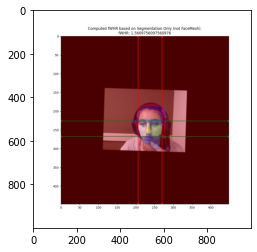

In [35]:
plt.imshow(arr)

## The Endpoint
### Notes
1. Is a blob a dictionary?  If so, this should work. Use the "json editor" on create a deployment.
2. https://www.freecodecamp.org/news/what-we-learned-by-serving-machine-learning-models-using-aws-lambda-c70b303404a1/https://www.freecodecamp.org/news/what-we-learned-by-serving-machine-learning-models-using-aws-lambda-c70b303404a1/

## Notes
1. is there a way to create the blob without importing ubiops? Yes (requests)
2. does requests encrypt my api key in transit?  Does ubiops?
3. make the request asynchronous, non-blocking
4. the documentation here, I think the vocabulary is confusing.  https://ubiops.com/docs/tutorials/quickstart/
(try just using code samples?)  I didn't find any code samples to show how to actually make a request.
5. Can I generalize the ubiops to make it work for multiple deployments?
    1. makes requests (async/await)
    2. parses response
    3. serializes and saves data
    4. caches requests
    
